In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

import scipy.stats as stats
import statsmodels.tsa.api as smt_api
import statsmodels.graphics.tsaplots as smg
import statsmodels.stats.diagnostic as sms_diag
from arch import arch_model

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Load data

In [2]:
returns = pd.read_excel('portf_returns.xlsx').set_index('Date').rename(columns={0: 'ret'})
returns.head()

,ret
Date,
2019-01-03,-0.007011
2019-01-04,0.012053
2019-01-07,0.003676
2019-01-08,0.002793
2019-01-09,0.001931


In [3]:
def plot_data_qqplot(data, title, percent):
    fig = plt.figure(figsize=(10,8), layout='tight')
    axs = fig.subplot_mosaic([['data', 'data'],
                              ['hist', 'normplot']],
                             height_ratios=[2,3])
    # plot the data
    axs['data'].plot(data)
    axs['data'].axhline(0, c='k', ls=':', lw=.5)
    axs['data'].set_title("Data")

    # plot an histogram + kde + MLE normal fit
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 200)
    pdf_norm = stats.norm.pdf(x, loc=mu, scale=sigma)
    sns.histplot(data, ax=axs['hist'], bins=35, kde=True, stat='density', legend=False)
    axs['hist'].plot(x, pdf_norm, c='r', lw=2)    
    label = f"Best normal fit\n($\mu$={mu:.2%}, $\sigma$={sigma:.2%})"
    lines = axs['hist'].get_lines()
    axs['hist'].legend(lines, ['kde', label], fontsize='small')
    axs['hist'].set_title("Histogram")

    if len(data.values.shape)==2:
        val = data.values[:,0]
    else:
        val = data.values
    stats.probplot(val, plot=axs['normplot'])
    axs['normplot'].set_title("Normal Probability plot")

    if percent:
        axs['data'].yaxis.set_major_formatter(mtick.PercentFormatter(1))
        axs['hist'].xaxis.set_major_formatter(mtick.PercentFormatter(1))
        
    fig.suptitle(title)
    

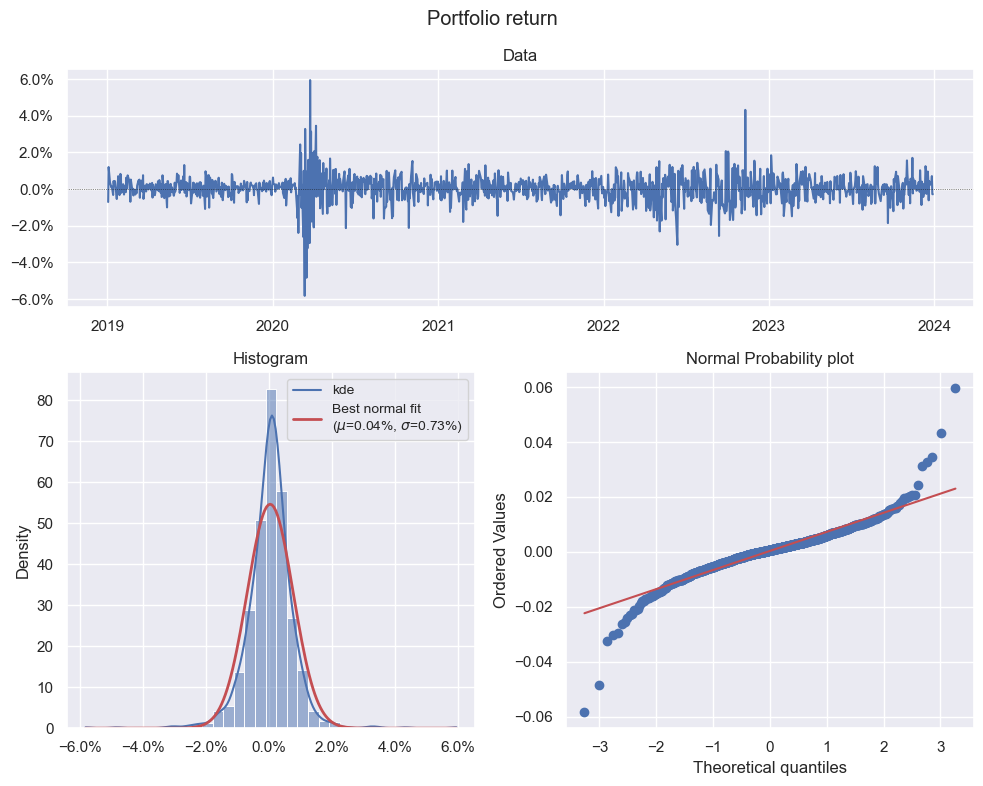

In [4]:
plot_data_qqplot(returns, "Portfolio return", percent=True)

# Tests of stationarity

## Augmented Dickey-Fuller unit root test
The **Null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root vs. the **Alternative hypothesis** of stationarity or trend stationarity (set by the `regression` parameter).  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [5]:
def print_adf_test(x):
    regressions = {'no constant, no trend': 'n',
                   'constant and trend': 'ct',
                   'constant only': 'c'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = smt_api.adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [6]:
res = print_adf_test(returns)

,test statistic,p-value
"no constant, no trend",-8.4528,0.0
constant and trend,-8.6442,0.0
constant only,-8.6014,0.0


## KPSS test
The null hypothesis for the KPSS test is
- `regression='c'`: the data is stationary around a constant (default).
- `regression='ct'`: the data is stationary around a trend.

<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html>

In [7]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [8]:
print_kpss_test(returns)

/var/folders/d5/d0x5h6650dx_qwvg0pwpw1q43rqlyr/T/ipykernel_76118/3396425873.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')
/var/folders/d5/d0x5h6650dx_qwvg0pwpw1q43rqlyr/T/ipykernel_76118/3396425873.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = smt_api.kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.2142,0.1
constant and trend,0.0764,0.1


# Testing for autocorrelation

## Plot the *autocorrelation* function and the *partial autocorrelation* function
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

In [9]:
def plot_acf_pacf(x, lags=30):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    smg.plot_acf(x, lags=lags, ax=axs[0])
    smg.plot_pacf(x, lags=lags, ax=axs[1], method='yw')
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    for ax in axs:
        ax.hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
        ax.legend()

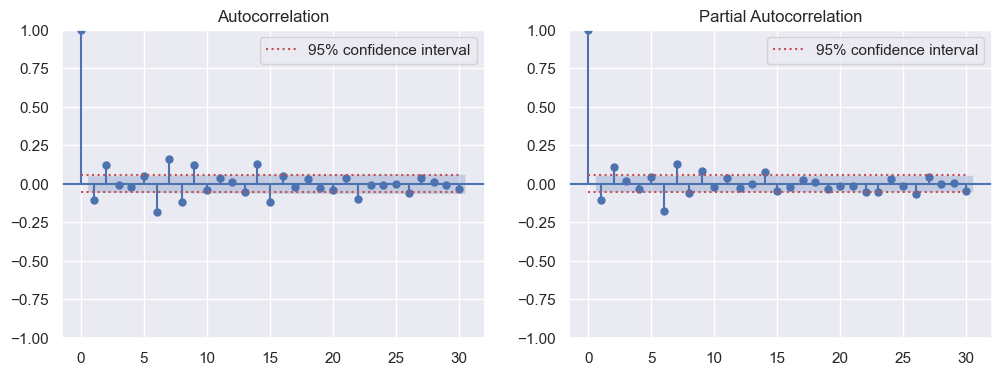

In [10]:
plot_acf_pacf(returns)

## Another view of autocorrelation

In [11]:
def scatter_plots(data, lags):
    fig, axs = plt.subplots(1, 2, figsize=(12,4), subplot_kw={'aspect': 'equal'})
    for ax, lag in zip(axs, lags):
        ax.scatter(data[:-lag], data[lag:], alpha=0.2, marker='.')
        ax.set_ylabel("data at time $t$")
        ax.set_xlabel(f"data at time $t-${lag}")
        ax.set_title(f"Autocorrelation at lag {lag}")

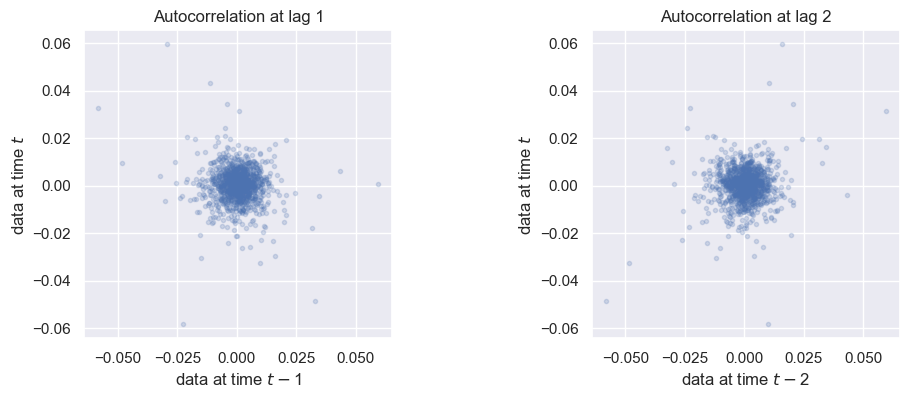

In [12]:
scatter_plots(data= returns    , lags=[1, 2])

The losses seem mostly independent, except for the large losses and gains during the pandemic in 2020.

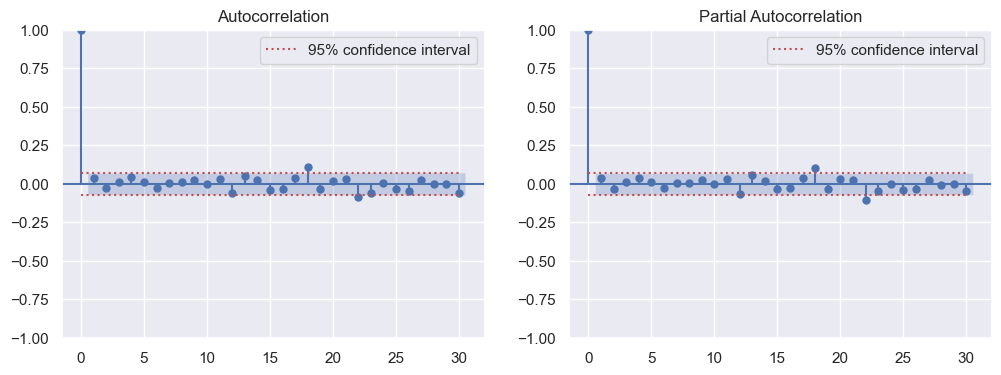

In [13]:
plot_acf_pacf(returns['2021':])

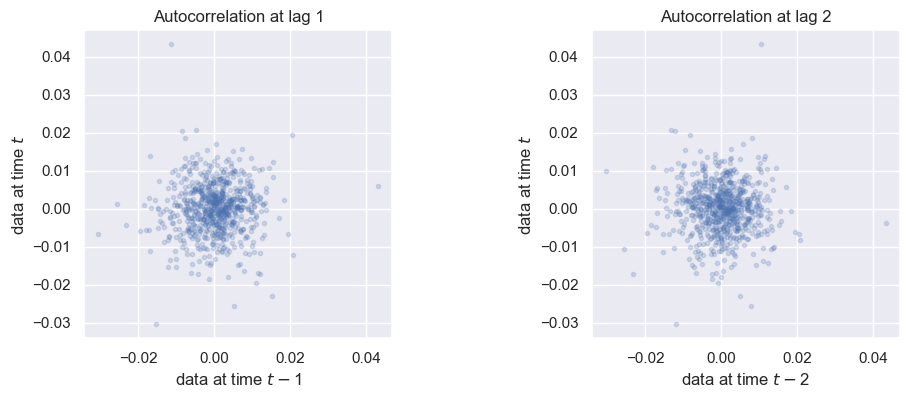

In [14]:
scatter_plots(data=returns['2021':] , lags=[1, 2])

## Ljung-Box Q test

The `acf` function returns the acf values, . With the parameter `qstat=True`, it returns the Ljung-Box Q statistic and its p-values, computed for all lags up to `nlags`.\
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html>

In [15]:
def print_acf(x, lags):
    val, qstat, pval = smt_api.acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)

In [16]:
test_lags = np.array([1, 2, 3, 5, 7, 10])
print_acf(returns, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,13.99,0.02
up to lag 2,31.94,0.00
up to lag 3,31.99,0.00
up to lag 5,35.86,0.00
up to lag 7,112.24,0.00
up to lag 10,149.54,0.00


In [17]:
print_acf( returns['2021':], lags=test_lags      )

,Q Statistic,p-value (%)
up to lag 1,1.02,31.29
up to lag 2,1.72,42.34
up to lag 3,1.83,60.83
up to lag 5,3.30,65.42
up to lag 7,3.82,80.01
up to lag 10,4.51,92.14


# Testing for Conditional Heteroscedasticity

## Autocorrelation in the squared values

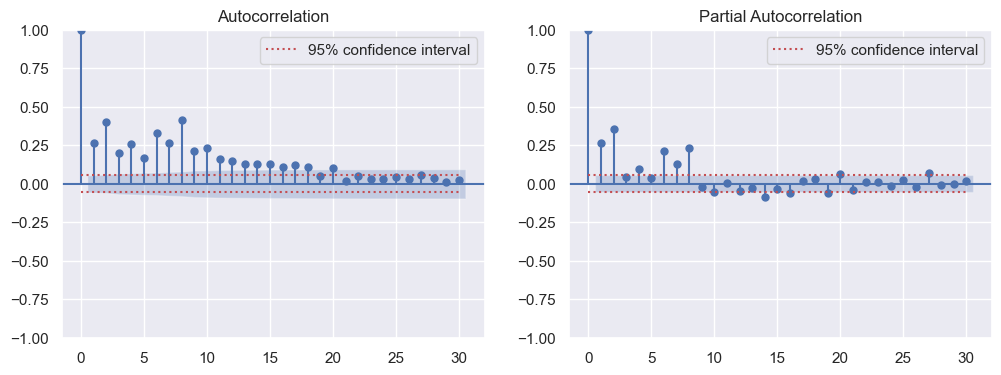

In [18]:
plot_acf_pacf(returns**2)

In [19]:
print_acf( returns**2 , lags=test_lags      )

,Q Statistic,p-value (%)
up to lag 1,89.86,0.0
up to lag 2,293.38,0.0
up to lag 3,344.18,0.0
up to lag 5,466.30,0.0
up to lag 7,689.22,0.0
up to lag 10,1029.73,0.0


## Engle’s Test for Autoregressive Conditional Heteroscedasticity
<https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_arch.html>  

*The Null Hypothesis is that there is no ARCH effect*.

In [20]:
def print_engle_test(x):
    res = sms_diag.het_arch(x, nlags=min(10, len(x)//5))
    df = pd.DataFrame(data = np.array(res).reshape(2,2),
                      columns=['test statistic', 'p-value'],
                      index=['Lagrange Multiplier', 'F test'])
    print("Engle's ARCH Test")
    display(df.round(4))
    return df

Apply to the returns.

In [21]:
res = print_engle_test( returns )

Engle's ARCH Test


,test statistic,p-value
Lagrange Multiplier,362.3297,0.0
F test,50.6060,0.0


In [22]:
returns.mean()

ret    0.000359
dtype: float64

# Fitting a GARCH(p,q) model

**Note**: *In the `arch` library, the parameter $p$ is for the number of ARCH lags and the parameter $q$ is for the number of GARCH lags.*  

We use a GARCH($p, q$) model with a mean equal to 0 with the parameter `mean='Zero'`. The returns are driven by the following equations:  
$$\begin{align}
r_t &= \sigma_t \varepsilon_t\\
\sigma_t^2 &= \omega + \sum_{i=1}^p \alpha_i r_{t-i}^2  + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{align}$$   

We use the `arch` library.
1. create an `ARCHmodel object` using the model constructor `arch_model()`.
2. use the `fit()` method of the `ARCHmodel object` and store the result.
3. the result is an object of the class `ARCHModelResult` that we can now use.

*links:*
- Introduction to ARCH Models: https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model
- `arch` library: https://arch.readthedocs.io/en/latest/index.html
- `ARCHModel` class: https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModel.html
  - `fit` method of the class: https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModel.fit.html
  - `ARCHModelResult` class: https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html

## Selecting a model with Information Criteria

This function estimate some GARCH models and store their AIC and BIC values in two DataFrame.

In [23]:
def select_garch(x, max_arch=2, max_garch=2, mean='Zero'):
    """
    Compute and store the AIC and BIC values for all GARCH models
    with 1 <= ARCH lags  <= max_arch
    and  0 <= GARCH lags <= max_garch
    Returns two DataFrames, first with AIC values, second with BIC values
    """
    # create the row and columns indices for the DataFrame
    row_index = pd.Index(data=np.arange(max_arch)+1, name='ARCH Lags')
    col_index = pd.Index(data=np.arange(max_garch+1), name='GARCH Lags')
    
    # create the DataFrames with zeros everywhere
    aic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    bic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    
    # loop on ARCH lags and GARCH lags
    for i in range(max_arch):
        for j in range(max_garch+1):
            # estimate the model and save AIC and BIC
            model = arch_model(x, p=i+1, q=j, mean=mean)
            res = model.fit(update_freq=0, disp='off')
            aic.iloc[i, j] = res.aic
            bic.iloc[i, j] = res.bic
    
    # find the row and column index of the minimum value in the AIC DataFrame
    # and store the corresponding order of the GARCH model in a tuple
    r_min, c_min = np.unravel_index(np.argmin(aic), aic.shape)
    aic_min_order = (row_index[r_min], col_index[c_min])
    
    # same for BIC
    r_min, c_min = np.unravel_index(np.argmin(bic), bic.shape)
    bic_min_order = (row_index[r_min], col_index[c_min])
    
    # display the results
    display(aic.round(1))
    print(f'AIC selected order: {aic_min_order}')
    display(bic.round(1))
    print(f'BIC selected order: {bic_min_order}')
    
    # return the two DataFrame
    return aic, bic

Apply this function to our data.  
We scale the returns for better numerical results.

In [24]:
aic, bic = select_garch(100*returns, max_arch=3, max_garch=3, mean='Zero')

GARCH Lags,0,1,2,3
ARCH Lags,,,,
1,2543.9,2299.1,2301.0,2302.1
2,2397.2,2301.1,2301.0,2303.0
3,2367.8,2303.1,2303.0,2305.7


AIC selected order: (1, 1)


GARCH Lags,0,1,2,3
ARCH Lags,,,,
1,2554.2,2314.5,2321.5,2327.8
2,2412.6,2321.7,2326.7,2333.9
3,2388.4,2328.8,2333.9,2341.6


BIC selected order: (1, 1)


## Fit the model selected by AIC and BIC
Use the  `summary()` method of the `ARCHModelResult` object to display the estimated model.  
https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html

Fit a **GARCH(1,1)** model to the data.

In [25]:
model = arch_model(100*returns, p=1, q=1, mean='Zero')
res_garch11 = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 659742315.6726791
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1158.7664279361034
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1177.4392864538845
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1148.386605225926
Iteration:      5,   Func. Count:     28,   Neg. LLF: 1170.7457473973002
Iteration:      6,   Func. Count:     33,   Neg. LLF: 1147.9696011961664
Iteration:      7,   Func. Count:     38,   Neg. LLF: 1146.5751826796318
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1146.5622559637613
Iteration:      9,   Func. Count:     47,   Neg. LLF: 1146.5622536458209
Iteration:     10,   Func. Count:     50,   Neg. LLF: 1146.5622536456738
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1146.5622536458209
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


In [26]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1146.56
Distribution:                  Normal   AIC:                           2299.12
Method:            Maximum Likelihood   BIC:                           2314.54
                                        No. Observations:                 1258
Date:                Tue, Mar 26 2024   Df Residuals:                     1258
Time:                        07:51:18   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.7060e-03  3.570e-03      1.878  6.033e-02 [-2.913e-04,1.370e-02]
alpha[1]       0.0932  2.174e-02      4.289  1.793e-05    [5.063e-02,  0.136]
beta[1]        0.8943  2.559e-02     34.948 1.376e-267      [  0.844,  0.944]
=============================================================================

Covariance estimator: robust
"""

##  Residuals analysis

We study the **standardized residuals**, that is $\varepsilon_t = r_t / \sigma_t$, which are in the `std_resid` attribute of the `ARCHModelResult` class.

In [27]:
residuals = res_garch11.std_resid / 100

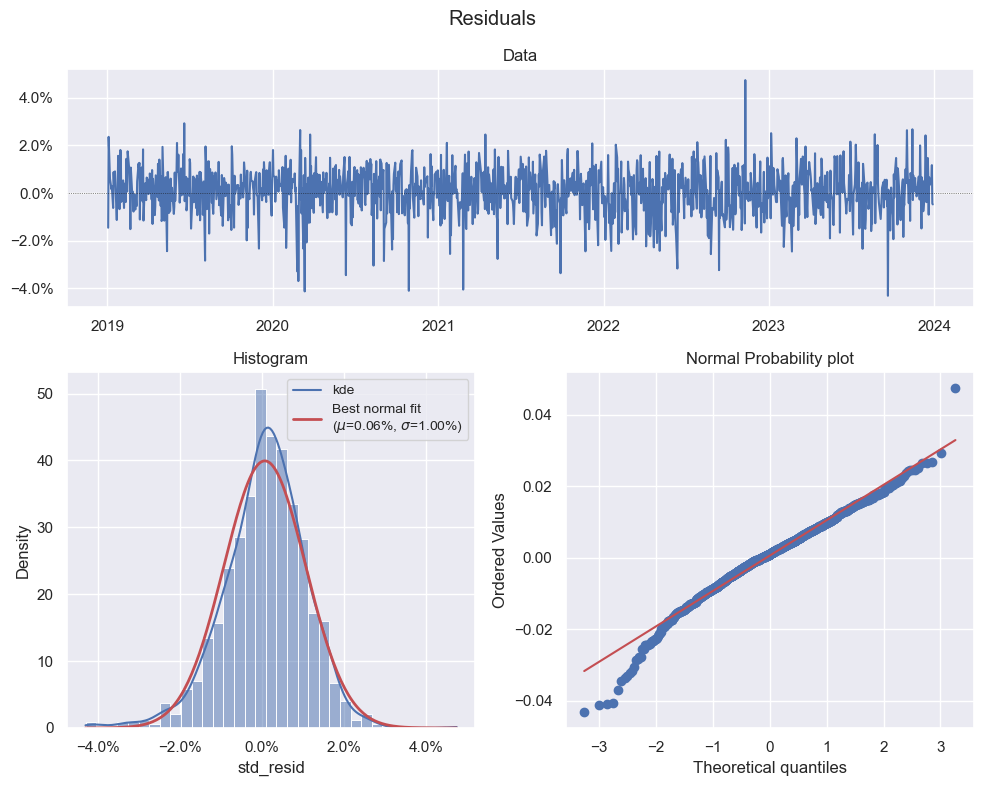

In [28]:
plot_data_qqplot(residuals, "Residuals", percent=True)

## Conditional Volatility

In [29]:
def plot_volatilities(data, garch_vol, period=65, lam=0.94):
    rolling_vol = data.rolling(period).std()
    EWMA_vol = data.ewm(alpha=1-lam).std()
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8), height_ratios=[2,3])
    ax1.plot(data)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax2.plot(garch_vol, lw=2, label="GARCH conditional volatility")
    ax2.plot(rolling_vol, ls='--', label=f"{period}-days rolling volatility")
    ax2.plot(EWMA_vol, ls='-.', label=f"EWMA volatility ($\lambda$={lam})")
    ax2.axhline(0, ls=':', c='k', lw=0.5)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax2.legend()
    

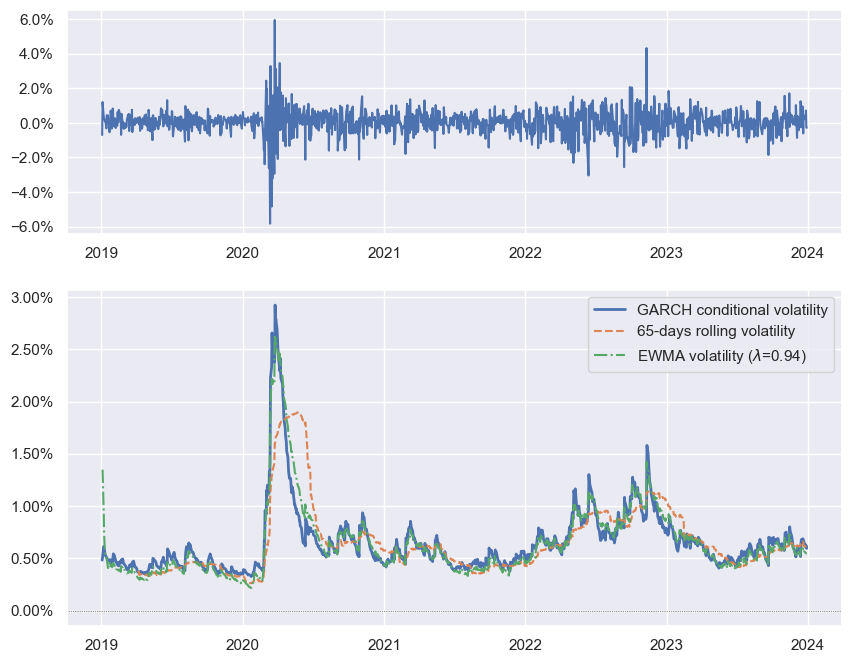

In [30]:
cond_vol = res_garch11.conditional_volatility / 100
plot_volatilities(returns, cond_vol)

In [32]:
returns['GARCH_cond_vol'] = cond_vol
returns.head()

,ret,GARCH_cond_vol
Date,,
2019-01-03,-0.007011,0.004822
2019-01-04,0.012053,0.005103
2019-01-07,0.003676,0.006124
2019-01-08,0.002793,0.005956
2019-01-09,0.001931,0.005755


# GARCH-weighted Historical Value-at-Risk

In [33]:
returns['ret_GARCH_weighted'] = returns['ret'] / returns['GARCH_cond_vol'] * returns['GARCH_cond_vol'].iloc[-1]
returns.tail()

,ret,GARCH_cond_vol,ret_GARCH_weighted
Date,,,
2023-12-22,0.002198,0.006517,0.002009
2023-12-26,0.003298,0.006253,0.003141
2023-12-27,0.007107,0.006054,0.006992
2023-12-28,-0.002685,0.006177,-0.002589
2023-12-29,-0.002826,0.005956,-0.002826


In [34]:
def plot_GARCH_weighted_returns(data):
    col_names = ['ret', 'ret_GARCH_weighted']
    labels = ["Raw returns", "GARCH Volatility-weighted returns"]

    fig, axs = plt.subplots(2, figsize=(10,5), sharex=True, sharey=True)
    for ax, name, label in zip(axs, col_names, labels):
        ax.plot(returns[name])
        ax.set_title(label)
        ax.axhline(0, c='k', ls=':', lw=.5)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


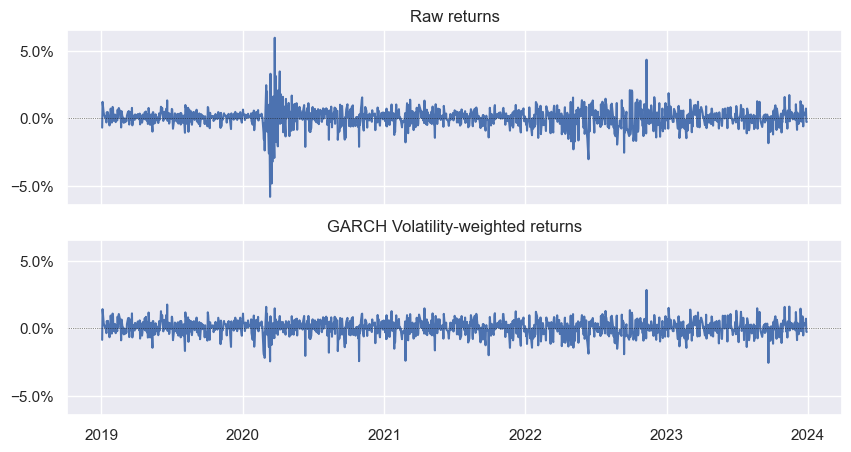

In [35]:
plot_GARCH_weighted_returns(returns)

In [36]:
returns['loss_GARCH_weighted'] = -1e2 * returns['ret_GARCH_weighted']
returns.tail()

,ret,GARCH_cond_vol,ret_GARCH_weighted,loss_GARCH_weighted
Date,,,,
2023-12-22,0.002198,0.006517,0.002009,-0.200855
2023-12-26,0.003298,0.006253,0.003141,-0.314120
2023-12-27,0.007107,0.006054,0.006992,-0.699167
2023-12-28,-0.002685,0.006177,-0.002589,0.258895
2023-12-29,-0.002826,0.005956,-0.002826,0.282610


In [37]:
alpha = 0.95
quantile_pos = int(alpha * len(returns))
quantile_pos

1195

In [38]:
VaR_GARCH_weight = returns['loss_GARCH_weighted'].iloc[quantile_pos]
print(f"The GARCH conditional volatility-weighted VaR at {alpha:.1%} confidence level is {VaR_GARCH_weight:.3f} m€")

The GARCH conditional volatility-weighted VaR at 95.0% confidence level is 1.152 m€
